In [1]:
import chirho.observational.handlers
import pyro
import torch
import pyro.distributions as dist
from chirho.interventional.handlers import Interventions, do
from chirho.counterfactual.handlers.counterfactual import TwinWorldCounterfactual
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.indexed.ops import gather, IndexSet
from functools import singledispatch
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoNormal
from functools import partial
from chirho.indexed.ops import gather, IndexSet
from chirho.observational.handlers import condition
from chirho.observational.handlers.condition import Observations
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
from itertools import product
from random import randint
from contextlib import nullcontext
import matplotlib
from utils.build_svi_iter import build_svi_iter
from utils.build_zuko_guide import build_zuko_guide, ZukoGuide
from utils.functional_factor_added import FunctionalFactorAdded
from utils.tabi_reparametrized_functional import TABIReparametrizedFunctionalOfPrior
from chirho.observational.handlers.predictive import PredictiveModel
import seaborn as sns
from chirho.robust.ops import influence_fn
# from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator
from chirho.robust.internals.full_linearize_from_left import full_linearize_from_left
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood

tnsr = torch.tensor

# Settings
pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)


# seed = randint(0, int(1e6))
# print(seed)

seed = 2805018

pyro.set_rng_seed(seed)

# Simple Model

In [2]:
# Sample from an MVN by sampling two normals sequentially.
class ChainedNormals(torch.nn.Module):
    def __init__(self, loc, cov, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.loc1 = loc[0]
        self.std1 = torch.sqrt(cov[0, 0])
        
        self.loc2_base = loc[1]
        self.sigma_21 = cov[1, 0]
        self.sigma_11 = cov[0, 0]
        self.sigma_22 = cov[1, 1]
        
        # Precompute part of the conditional mean expression
        self.conditional_loc2_base = self.loc2_base - (self.sigma_21 / self.sigma_11) * self.loc1
        self.conditional_std2 = torch.sqrt(self.sigma_22 - (self.sigma_21**2 / self.sigma_11))
    
    def forward(self):
        # Sample from the first normal distribution
        z1 = pyro.sample("z1", dist.Normal(
            loc=self.loc1,
            scale=self.std1
        ))
        
        # Compute the conditional mean using the sampled z1
        conditional_loc2 = self.conditional_loc2_base + (self.sigma_21 / self.sigma_11) * z1
        
        # Sample from the second normal distribution with the conditional mean
        z2 = pyro.sample("z2", dist.Normal(
            loc=conditional_loc2,
            scale=self.conditional_std2
        ))
        
        return z1, z2

In [3]:
prior = ChainedNormals(
    loc=torch.tensor([0., 0.]),
    cov=torch.tensor([
        [5.0, -0.0],
        [-0.0, 5.0]
    ])
)

(-6.0, 6.0)

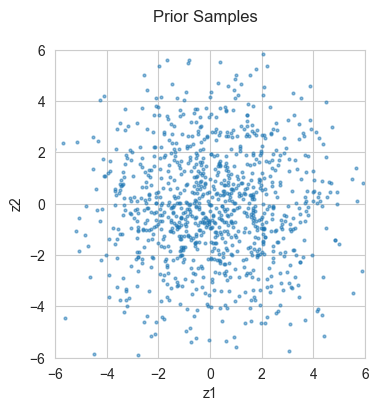

In [4]:
# Visualize samples from the prior.
with pyro.plate("prior_viz", 1000):
    prior_samples = prior()

plt.figure(figsize=(4, 4))
plt.scatter(prior_samples[0].detach().numpy(), prior_samples[1].detach().numpy(), alpha=0.5, s=4.)
plt.xlabel("z1")
plt.ylabel("z2")
plt.suptitle("Prior Samples")

LIMS = (-6., 6.)
plt.xlim(*LIMS)
plt.ylim(*LIMS)

In [5]:
class FullModel(torch.nn.Module):
    def __init__(self, prior: torch.nn.Module, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prior = prior
        self.noise = torch.tensor(0.5)
        
    def forward(self, n=1):
        ps = self.prior()  # prior sample
        
        # TODO make the normal prior just use a dict and not a tuple.
        #  The issue is that the tuple return makes it hard to use a
        #  guide in place of the prior, which returns a dict by default.
        if isinstance(ps, dict):
            z1, z2 = ps["z1"], ps["z2"]
        elif isinstance(ps, tuple):
            z1, z2 = ps
        else:
            raise NotImplementedError(f"Unknown prior sample type: {type(ps)}")
        
        with pyro.plate("data", n, dim=-1):
            x = pyro.sample("x", dist.Normal(z1 + z2, self.noise))
    
        return x
model = FullModel(prior)

# Data Generation

In [6]:
true_latents = dict(
    z1=tnsr([1.]),
    z2=tnsr([-3.])
)

In [7]:
N = 100
observed_data = dict(x=condition(partial(model, n=N), data=true_latents)())

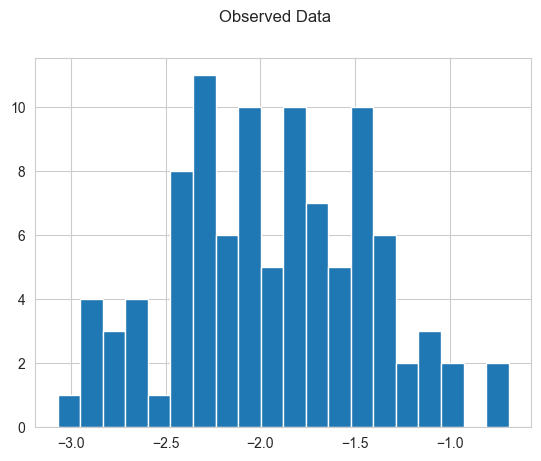

In [8]:
plt.hist(observed_data["x"].detach().numpy(), bins=20)
plt.suptitle("Observed Data")
pass

In [9]:
conditioned_model = condition(partial(model, n=N), data=observed_data)

# Inference

In [10]:
# # DEBUG
# class ManualGuide(torch.nn.Module):
#     def __init__(self, *args, **kwargs):
#         

In [11]:
svi = build_svi_iter(
    model=conditioned_model,
    lr=1e-3,
    
    variational_family=AutoMultivariateNormal,
    init_scale=4.0,
    
    # variational_family=AutoDelta,
    
    # variational_family=ZukoGuide,
    # features=2,
    # context=0,
    # transforms=1,
    # hidden_features=(4, 4)
)

In [12]:
# NITER = 15000
NITER = 1000  # DEBUG
for _ in range(NITER):
    print(f"Progress {_}/{NITER}", end="\r")
    svi.svi_iter()

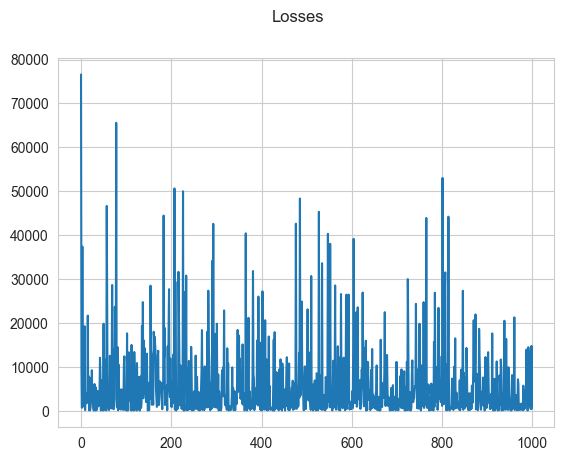

In [13]:
plt.plot(svi.losses)
plt.suptitle("Losses")
pass

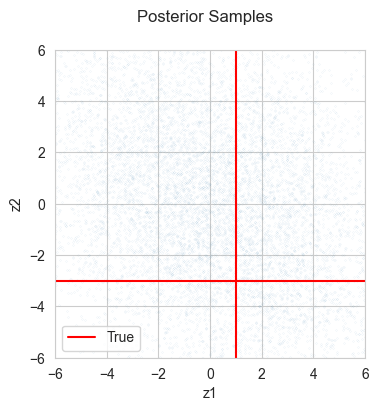

In [14]:
# Plot posterior samples.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = svi.guide()
    
plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.suptitle("Posterior Samples")
plt.xlim(*LIMS)
plt.ylim(*LIMS)
pass

# Functional
We're interested in the sum of `z1` and `z2`, but where we intervene to set `z2=0`.  

In [15]:
class IntervenedSum(torch.nn.Module):
    
    def __init__(self, model, z2value, num_monte_carlo, reshaper=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.z2value = z2value
        self.num_monte_carlo = num_monte_carlo
        self.reshaper = reshaper or (lambda x: x)
        
    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
            with do(actions=dict(z2=self.z2value)):
                x = self.model(*args, **kwargs)
                return self.reshaper(x)

In [16]:
functional = IntervenedSum(model, z2value=tnsr([0.]), num_monte_carlo=1000, reshaper=torch.mean)

In [17]:
# Failure to capture the true answer due to non-identification (true answer is 1.).
functional()

tensor(0.0013)

# Posterior Sensitivity

In [18]:
# Generate a grid of z1, z2 value pairs to assess sensitivity wrt.
GRID_RES = 300
z1_values = torch.linspace(*LIMS, GRID_RES)
z2_values = torch.linspace(*LIMS, GRID_RES)
z1_grid, z2_grid = torch.meshgrid(z1_values, z2_values, indexing='ij')

# And flatten into something we can pass to the influence function computation.
points = dict(z1=z1_grid.reshape(-1), z2=z2_grid.reshape(-1))

In [19]:
class IntervenedSum_FunctionalOfGuide(IntervenedSum):
    def __init__(self, guide, model, *args, **kwargs):
        super().__init__(PredictiveModel(model, guide), *args, **kwargs)

In [20]:
partial_funcofguide = partial(
    IntervenedSum_FunctionalOfGuide,
    model=model,
    z2value=tnsr([0.]),
    num_monte_carlo=3000,
    reshaper=torch.mean
)

In [21]:
partial_funcofguide(svi.guide)()

tensor(0.0290, grad_fn=<MeanBackward0>)

In [22]:
# HACK for now, because I couldn't figure out how to reliably get log probabilities out of an auto-guide or zuko guide.
class ManualLogProbComputer(torch.nn.Module):
    def __init__(self, guide):
        super().__init__()
        self.guide = guide
        
    def forward(self, points):
        stacked_points = torch.hstack((points["z1"][:, None], points["z2"][:, None]))
        posterior_dist = self.guide.get_posterior()
        return posterior_dist.log_prob(stacked_points)

In [23]:
with torch.no_grad():
    compute_posterior_inf_on_posterior_pred = full_linearize_from_left(
        svi.guide,
        functional=partial_funcofguide,
        num_samples_outer=int(3e3),  # number of samples used to estimate empirical fisher.
        num_samples_inner=1,  # not used for this b/c no marginalization required.
        points_omit_latent_sites=False,  # no marginalization of latents is required.
        # The parameter paths in the svi.guide module and functional differ, despite
        #  pointing to the same parameters. This option will try to remap matching
        #  parameters to have the same path.
        remap_parameter_paths=True,
        log_prob_computer=ManualLogProbComputer,
        predictive_sites=("z1", "z2"),
    )

In [24]:
import time
few_points = {k: v for k, v in points.items()}
with torch.no_grad():
    s = time.time()
    posterior_inf_on_posterior_pred = compute_posterior_inf_on_posterior_pred(few_points)
    print("Elapsed:", time.time() - s)
    print(posterior_inf_on_posterior_pred.shape)

Elapsed: 0.004705190658569336
torch.Size([90000])


### Visualize Posterior Sensitivity
The target functional is `E[x|D, do(z2=0)]`, where `x=z1+z2`. We estimate this with a variational approximation to the posterior over `z1` and `z2` conditioned on observations of their sum. Because `z2` is being forcibly set to zero here, the influence on the posterior expectation of `x` should be entirely the purview of `z1`. Indeed, we see that, only by adding probability mass to the right of the posterior mean of `z1`, will the target functional increase. By adding mass to the left, the target functional will decrease.

Text(0.5, 0.98, 'Functional Sensitivity to Posterior Perturbations')

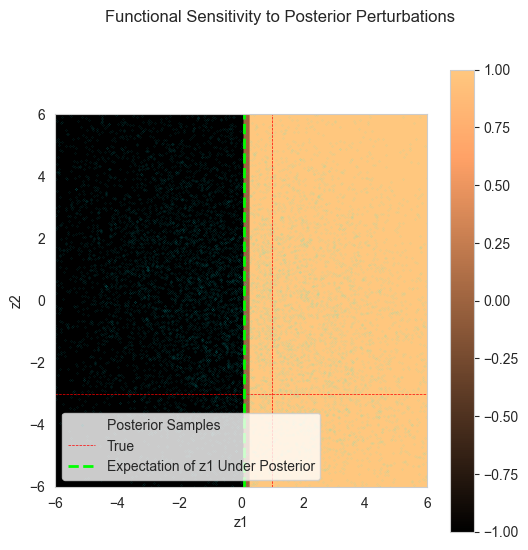

In [25]:
# Reshape the posterior_inf_on_posterior_pred to be used as the color
#  of our meshgrid plot.
posterior_inf_on_posterior_pred_grid = posterior_inf_on_posterior_pred.reshape(GRID_RES, GRID_RES)

# Plot the sensitivity of the posterior predictive to the posterior
#  distribution of the latent variables.
plt.figure(figsize=(6, 6))

# plt.imshow(
#     posterior_inf_on_posterior_pred_grid.T,
#     extent=(*LIMS, *LIMS), origin='lower',
#     cmap="copper"
# )

# Plot something a little more interpretable. We want to set -1 where < 0, 1 where > 0, and then keep 0 for isclose to zero for that contour.
simple_post_inf = posterior_inf_on_posterior_pred_grid.clone()
simple_post_inf[simple_post_inf < 0] = torch.tensor(-1.)
simple_post_inf[simple_post_inf > 0] = torch.tensor(1.)
simple_post_inf[torch.isclose(posterior_inf_on_posterior_pred_grid, torch.tensor(0.), atol=1e-1)] = torch.tensor(0.)
plt.imshow(
    simple_post_inf.T,
    extent=(*LIMS, *LIMS), origin='lower',
    cmap="copper"
)

plt.colorbar()
plt.xlabel("z1")
plt.ylabel("z2")

# Plot the truth and a low-alpha posterior scatter.
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=0.5, s=0.01, color="cyan", label="Posterior Samples")
plt.axvline(true_latents["z1"].item(), color="red", label="True", linewidth=0.5, linestyle="--")
plt.axhline(true_latents["z2"].item(), color="red", linewidth=0.5, linestyle="--")

# Force lims.
plt.xlim(*LIMS)
plt.ylim(*LIMS)

# Show the axvline for the functional's estimate under the current posterior.
plt.axvline(partial_funcofguide(svi.guide)().detach(), color="lime", label="Expectation of z1 Under Posterior", linewidth=2.0, linestyle="--")

# Remove grid lines.
plt.grid(False)

plt.legend()
plt.suptitle("Functional Sensitivity to Posterior Perturbations")

# Prior Sensitivity
We defined the earlier functional with respect to a posterior approximation. This meant we could merely slot that approximation in, in place of the prior, and compute the functional. Now, however, we want to rewrite the functional with respect to the prior, which is unfortunately obscured behind the posterior approximation, which is itself a functional of the prior that involves inference. To resolve this, we will use importance sampling in "reparametrization", of sorts, where inference still aids in our estimation, but where the functional can be written with respect to the prior more directly.

To do so, we'll use the single stage TABI decomposition, which involves adding a log factor for the quantity you wish to take the expectation with respect to.

In [58]:
partial_functional = partial(
    IntervenedSum,
    z2value=tnsr([0.]),
    num_monte_carlo=1000,
    reshaper=torch.mean
)

In [59]:
functional_of_prior_estimator = TABIReparametrizedFunctionalOfPrior(
    prior=prior,
    full_model_functional_of_prior=FullModel,
    data=observed_data,
    functional=partial_functional,
    num_monte_carlo=3000,
)

In [60]:
functional_of_prior_estimator.build_svi_iters(
    lr=1e-3,
    # variational_family=AutoMultivariateNormal,
    # init_scale=4.0
    
    variational_family=ZukoGuide,
    features=2,
    context=0,
    transforms=1,
    hidden_features=(4, 4)
)

In [61]:
# DEBUG testing just the posterior part.
NITER = 15000
for i in range(NITER):
    functional_of_prior_estimator.den_comp_svi_iter.svi_iter()
    print(f"Progress {i}/{NITER}", end="\r")

In [62]:
@singledispatch
def strip_for_plotting():
    raise NotImplementedError()

@strip_for_plotting.register(list)
def _(x):
    return [strip_for_plotting(v) for v in x]

@strip_for_plotting.register(torch.Tensor)
def _(x):
    return x.detach().numpy()

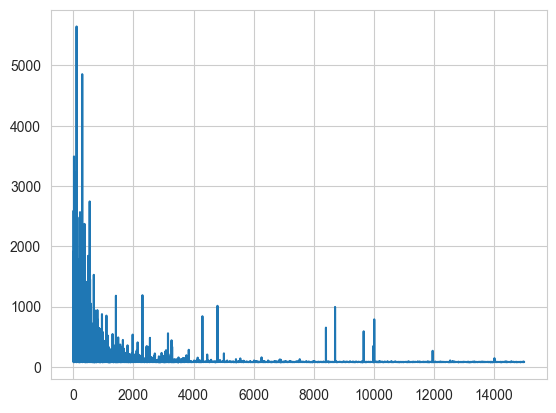

In [63]:
# DEBUG vis
plt.plot(
    strip_for_plotting(functional_of_prior_estimator.den_comp_svi_iter.losses)
)

(-6.0, 6.0)

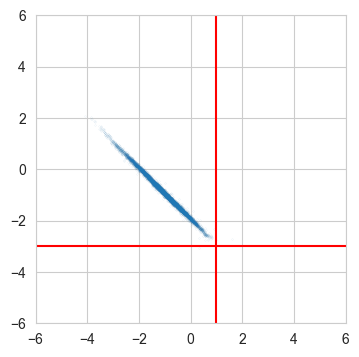

In [64]:
# DEBUG vis posterior, just like before.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = functional_of_prior_estimator.den_comp_svi_iter.guide()

plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlim(*LIMS)
plt.ylim(*LIMS)


In [65]:
# DEBUG do the same thing but for the positive component pos_comp_svi_iter
for i in range(NITER):
    functional_of_prior_estimator.pos_comp_svi_iter.svi_iter()
    print(f"Progress {i}/{NITER}", end="\r")


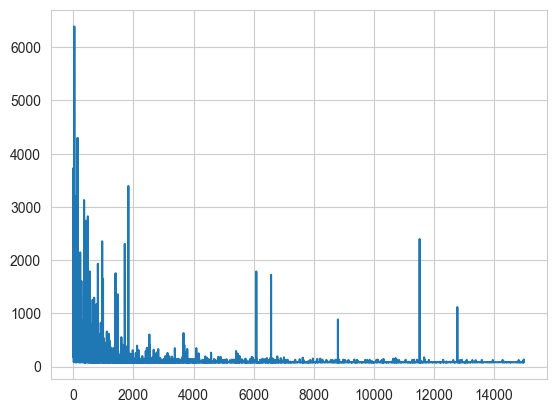

In [66]:
# DEBUG vis
plt.plot(
    strip_for_plotting(functional_of_prior_estimator.pos_comp_svi_iter.losses)
)

(-6.0, 6.0)

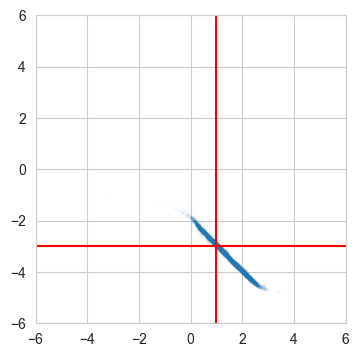

In [67]:
# DEBUG vis posterior, just like before.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = functional_of_prior_estimator.pos_comp_svi_iter.guide()

plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlim(*LIMS)
plt.ylim(*LIMS)


In [68]:
# And for neg_comp_svi_iter
for i in range(NITER):
    functional_of_prior_estimator.neg_comp_svi_iter.svi_iter()
    print(f"Progress {i}/{NITER}", end="\r")

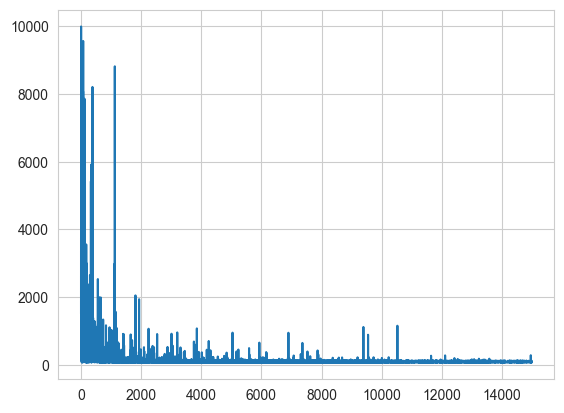

In [69]:
# DEBUG vis
plt.plot(strip_for_plotting(functional_of_prior_estimator.neg_comp_svi_iter.losses))

(-6.0, 6.0)

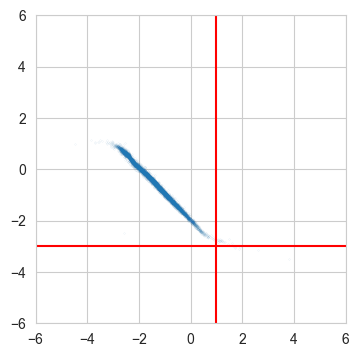

In [70]:
# DEBUG vis posterior, just like before.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = functional_of_prior_estimator.neg_comp_svi_iter.guide()
    
plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlim(*LIMS)
plt.ylim(*LIMS)

In [76]:
# DEBUG try forward.
functional_of_prior_estimator()

tensor(-0.6822, grad_fn=<SubBackward0>)